In [ ]:
import torch
import torchvision
from torch.optim import Adam
from PIL import Image
from data_utils.pre_process import load_image_paths_from_folder, load_images_and_labels, load_datasets, load_image_path_splits, preprocess_mask
import albumentations as A
import numpy as np
import matplotlib.pyplot as plt
import torch
import pytest
from lightning.pytorch import Trainer
from models.model_blocks import (
    UNetDecoderBlock,
    UNetEncoderBlock,
    UNetMidBlock,
    UNetDecoder,
    UNetEncoder
)
from models.unet import UNet

from data_utils.pre_process import ImageSegmentationDataset
from torch.utils.data import DataLoader, Dataset

# Load in trained model

In [6]:
model = UNet(in_channels=3,
             out_channels=64,
             kernel_size=3, 
            final_filters=1,
            encoder_dropout=0.22861)

ckpt = torch.load(
    "trained_models/best-epoch=26-val_loss=0.1842.ckpt",
    map_location="mps"
)

state_dict = ckpt["state_dict"]

new_state_dict = {
    k.replace("model.", ""): v
    for k, v in state_dict.items()
}

model.load_state_dict(new_state_dict)

model.eval()


UNet(
  (unet_encoder): UNetEncoder(
    (encoder_block_1): UNetEncoderBlock(
      (relu): ReLU()
      (conv_layer_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_layer_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (encoder_block_2): UNetEncoderBlock(
      (relu): ReLU()
      (conv_layer_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_layer_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (encoder_block_3): UNetEncoderBlock(
      (relu): ReLU()
      (drop): Dropout2d(p=0.22861, inplace=False)
      (conv_layer_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_layer_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1,

# Load in test data

In [ ]:
test_img_paths = []
test_lab_paths = []
with open("saved_data/test/images/image_paths.txt", "r") as f:
    for line in f:
        line = line.strip()   # removes \n and surrounding whitespace
        test_img_paths.append(line)

with open("saved_data/test/masks/label_paths.txt", "r") as f:
    for line in f:
        line = line.strip()   # removes \n and surrounding whitespace
        test_lab_paths.append(line)

val_test_transforms = A.Compose([
    A.Resize(512, 512),               
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                normalization="standard", # Default
                p=1.0),
    A.ToTensorV2()                          
])

test_dataset = ImageSegmentationDataset(image_path_list=test_img_paths,
                                        image_path_labels=test_lab_paths, 
                                        transforms=val_test_transforms)


In [87]:
test_dataloader = DataLoader(test_dataset,
                            batch_size=32,
                            shuffle=False,
                            num_workers=1,
                            persistent_workers=True)

# Run Model Inference

In [88]:
def convert_to_image(tens):
    # Move to CPU and convert to numpy
    img = tens.cpu().numpy()
    img = np.transpose(img, (1, 2, 0))

    # Undo normalization
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = ((img * std) + mean)
    img = np.clip(img * 255, 0, 255).astype(np.uint8)
    return img.astype(np.uint8)

In [89]:
test_x, test_y = next(iter(test_dataloader))
sigmoid = torch.nn.Sigmoid()
model_output = sigmoid(model(test_x))

In [ ]:
predicted_mask = (model_output >= 0.5).float()

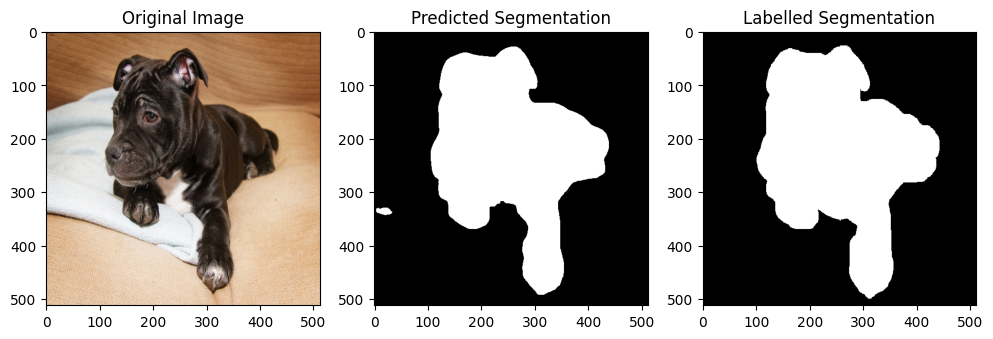

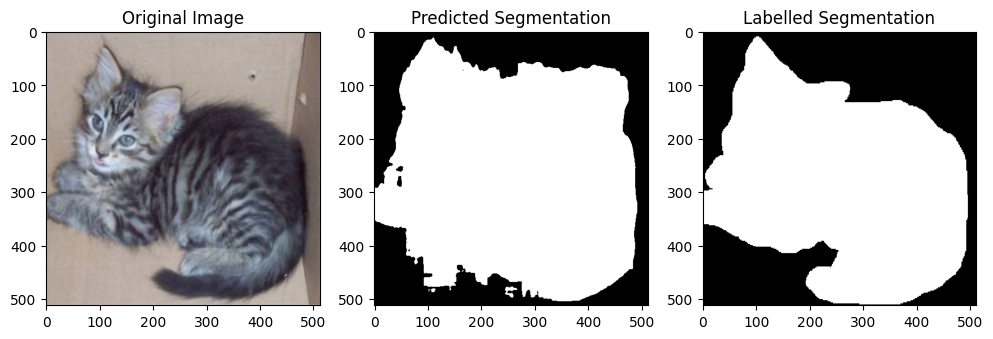

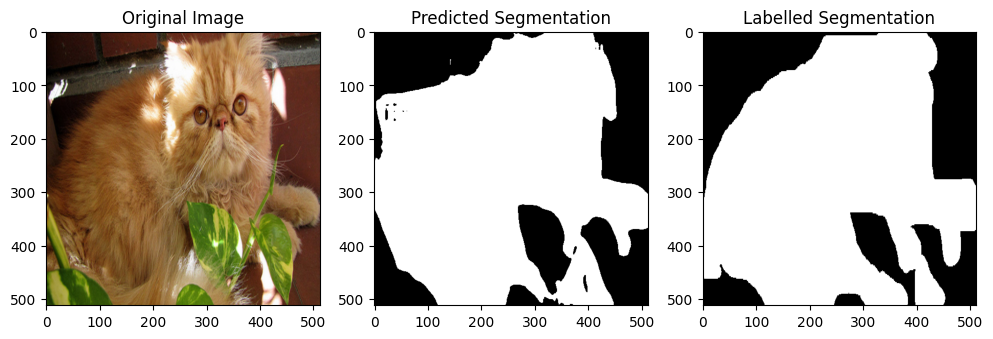

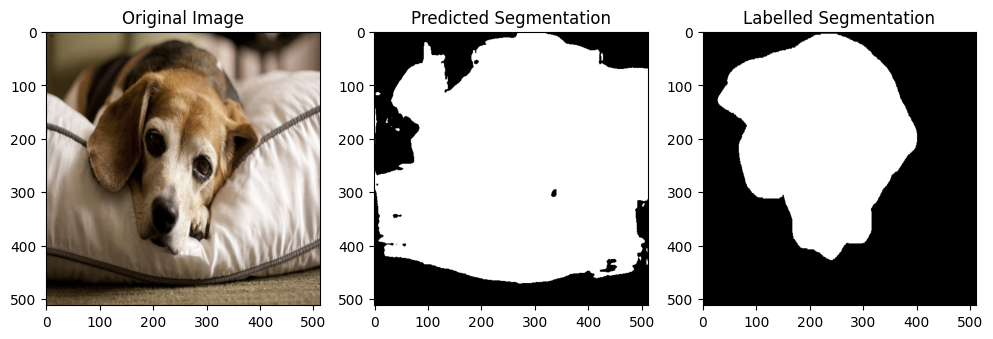

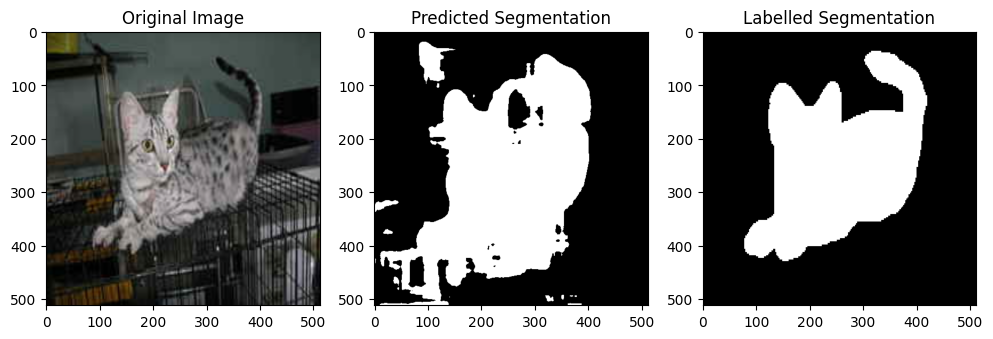

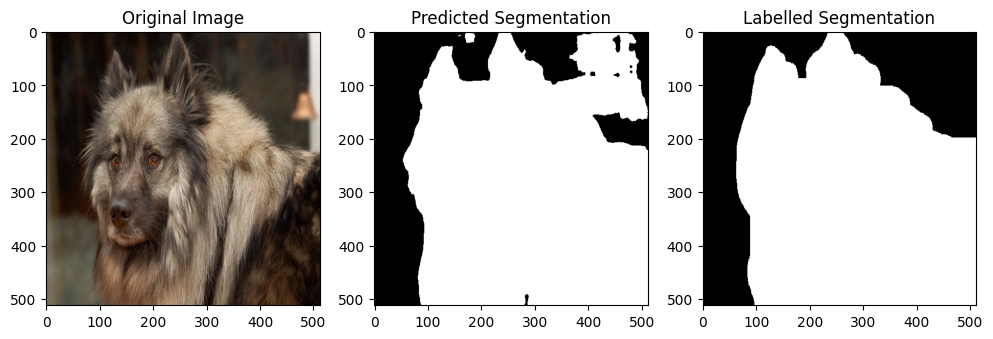

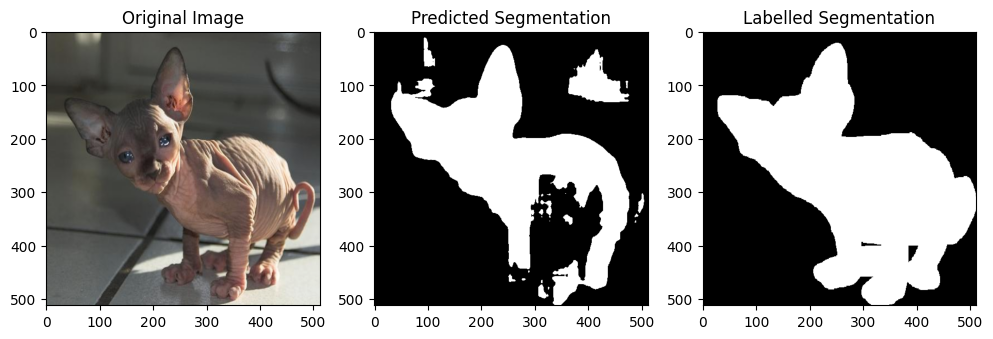

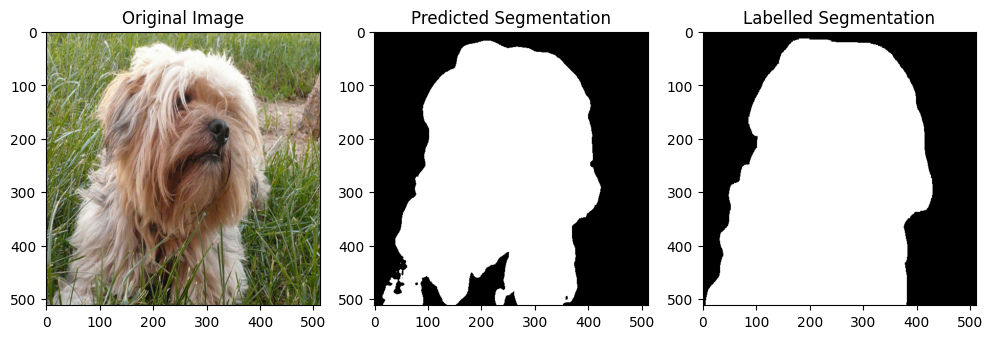

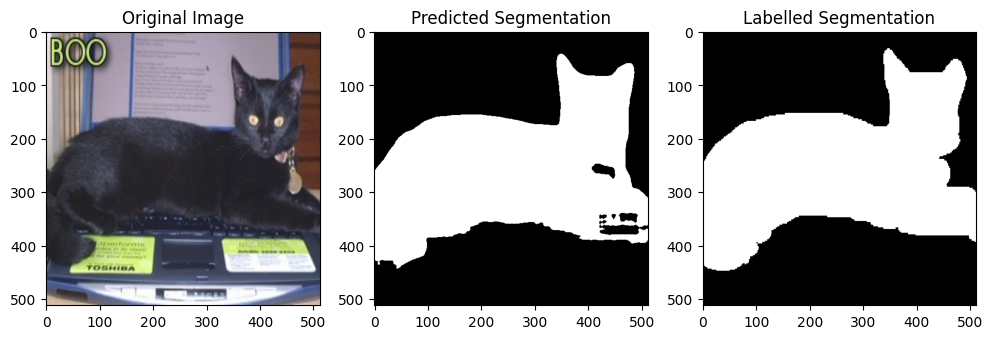

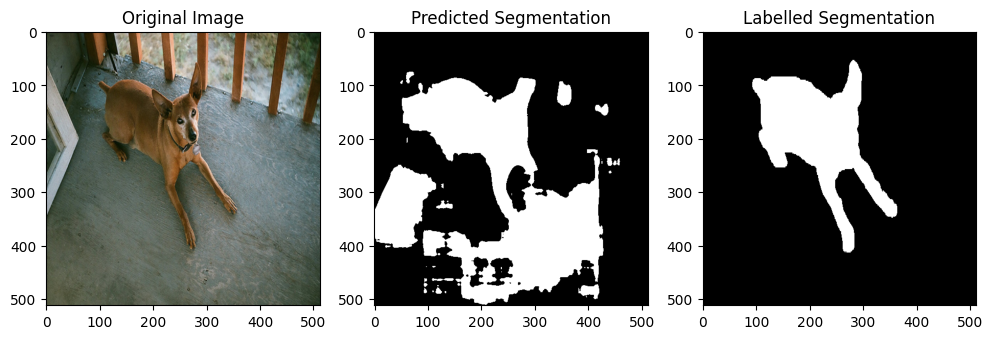

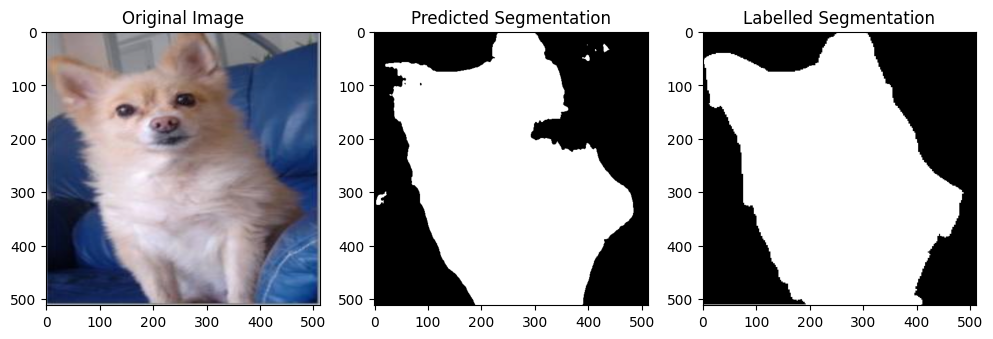

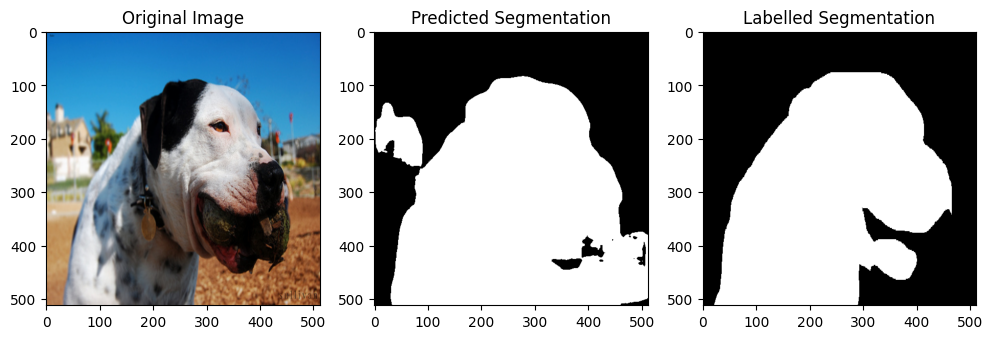

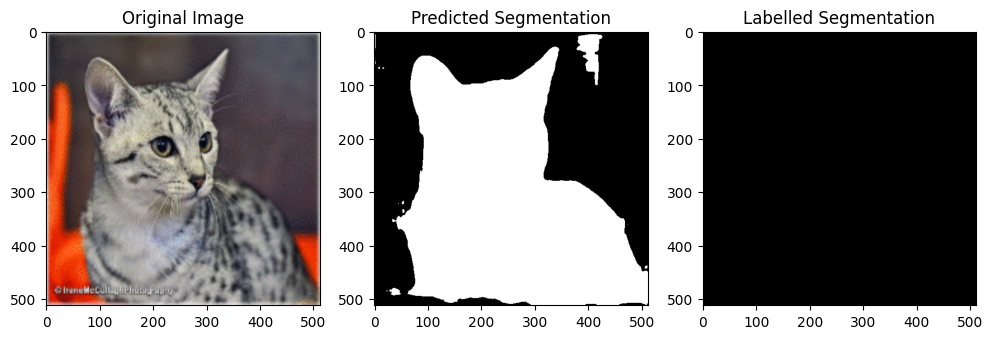

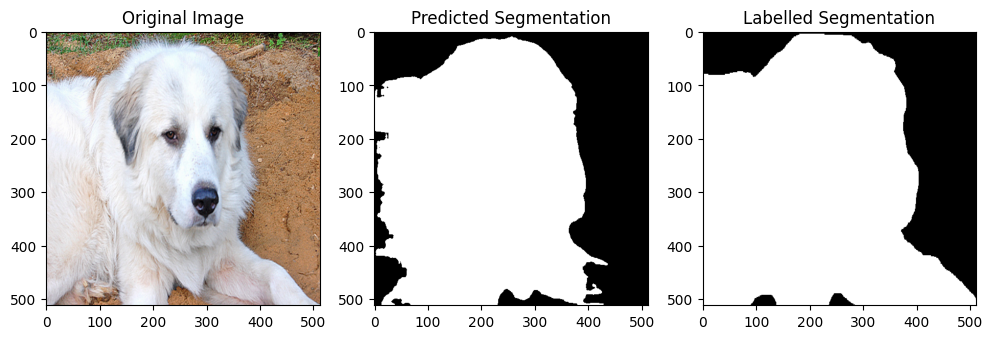

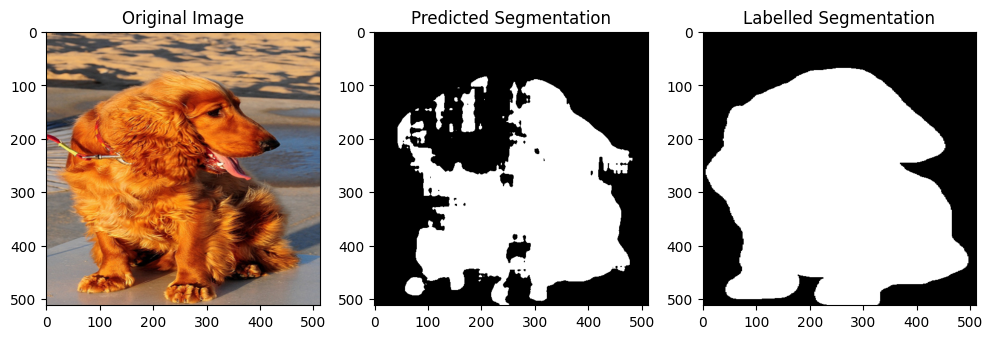

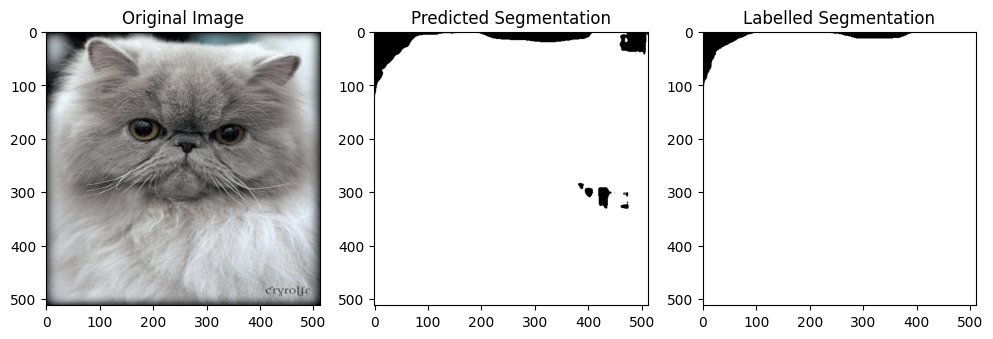

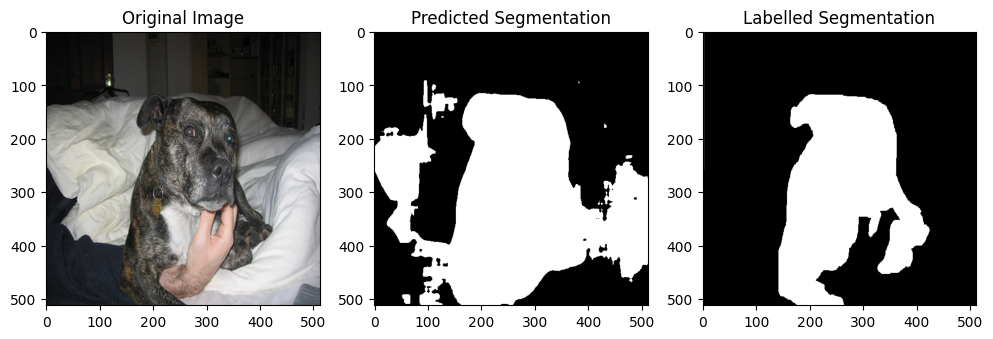

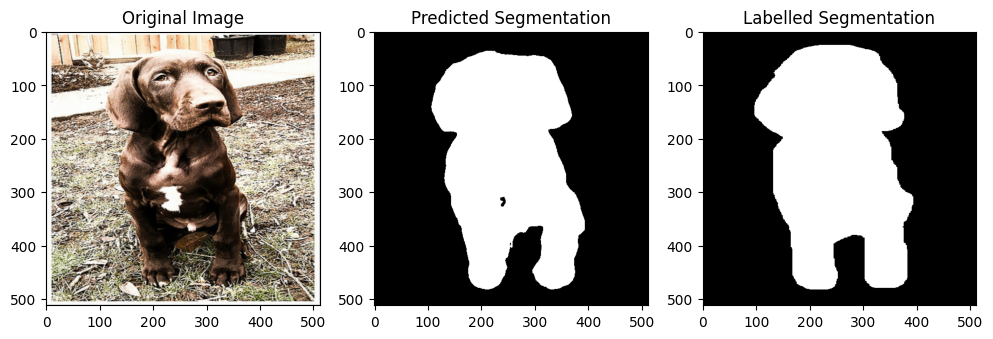

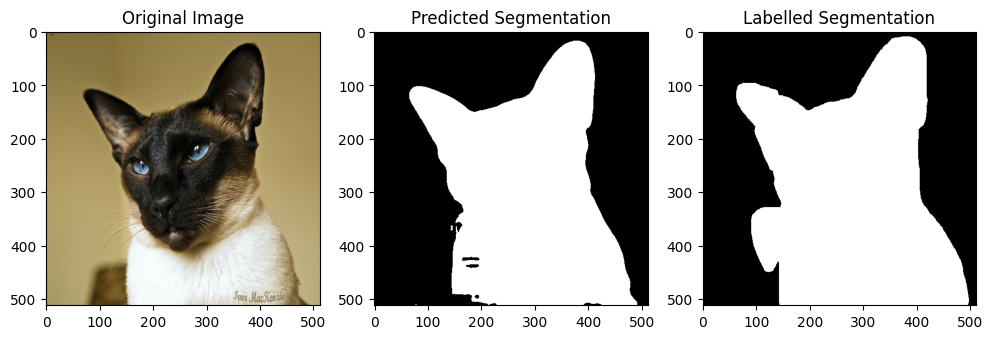

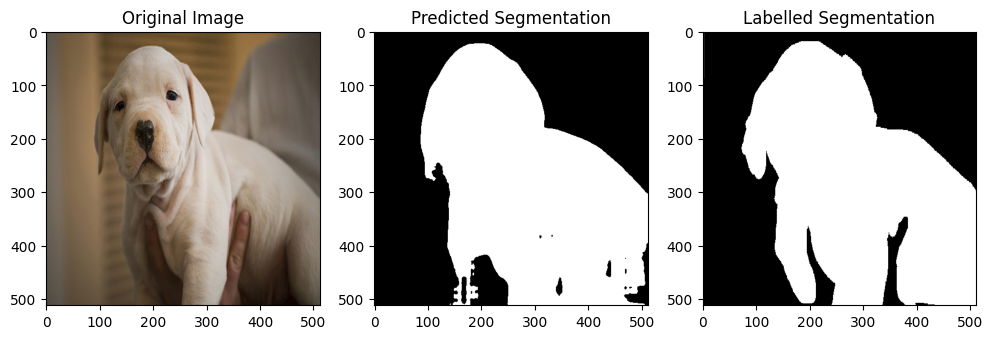

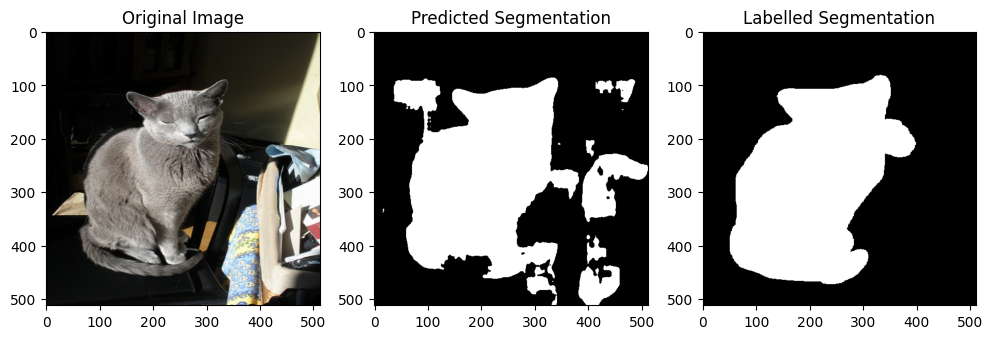

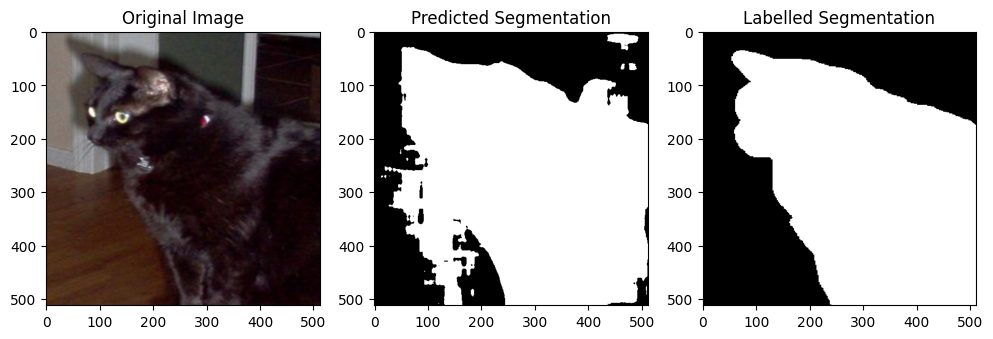

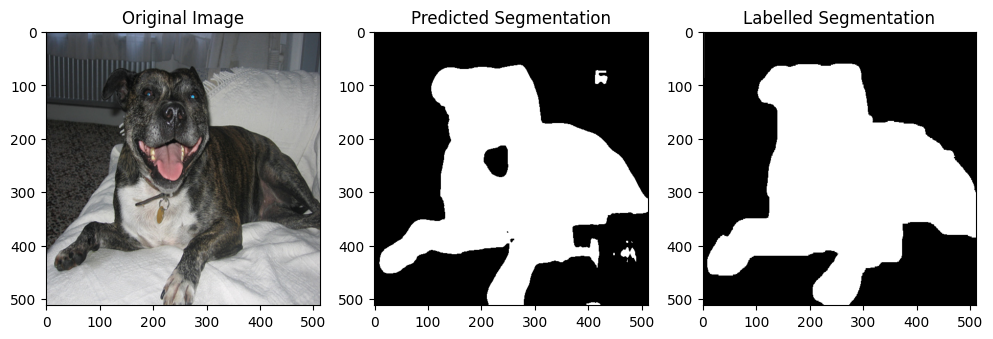

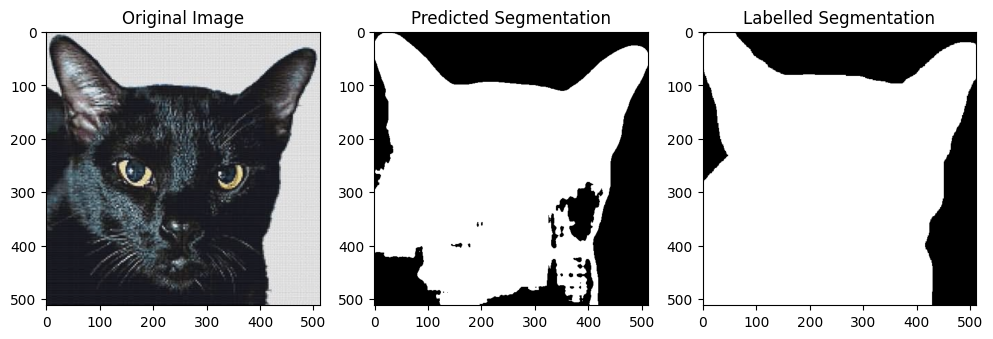

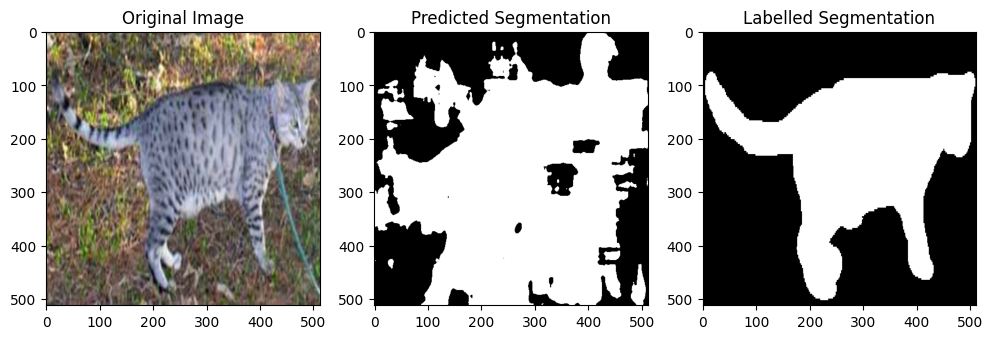

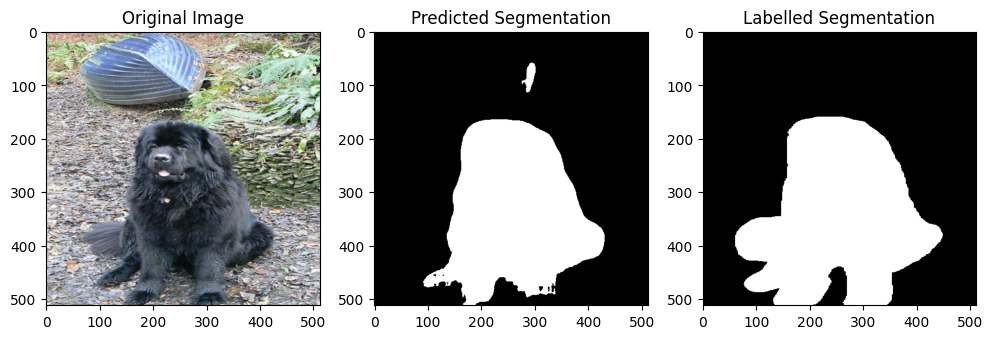

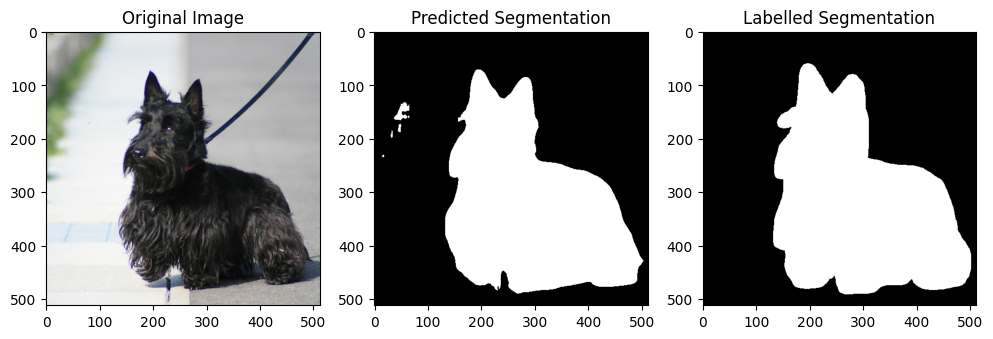

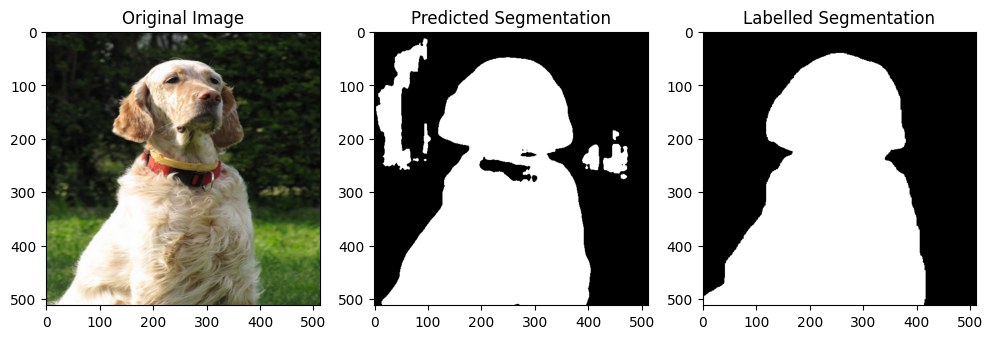

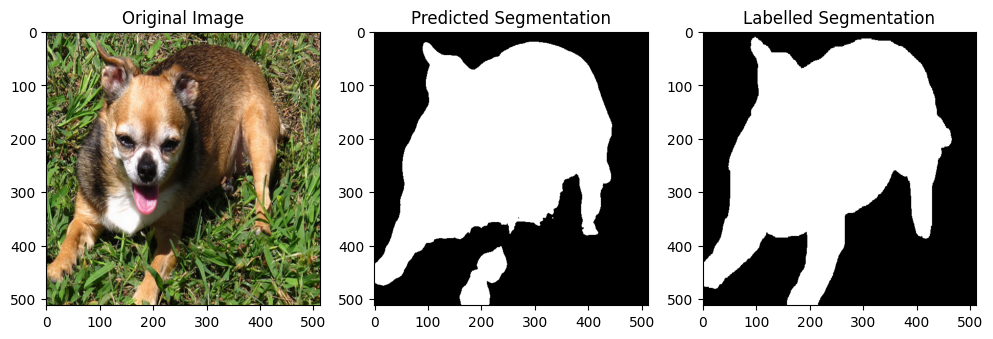

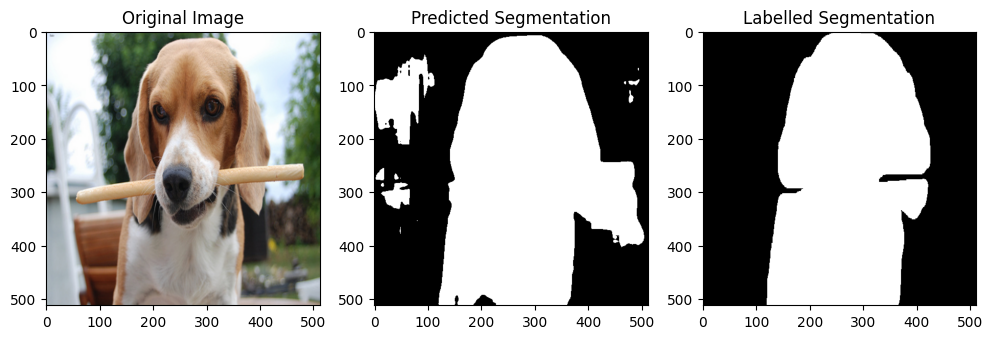

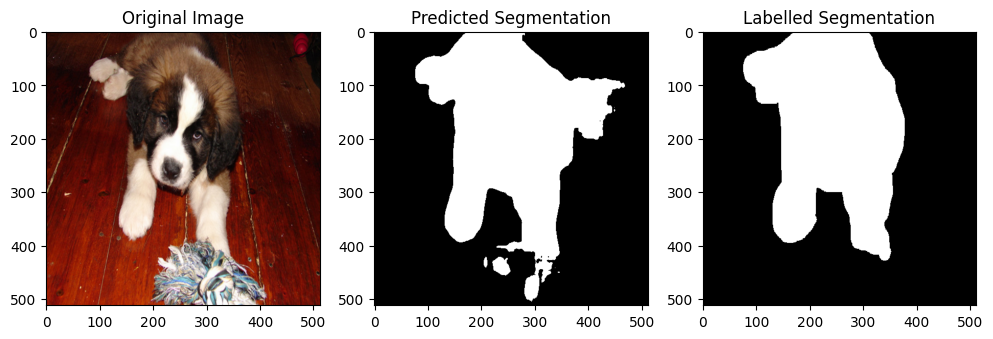

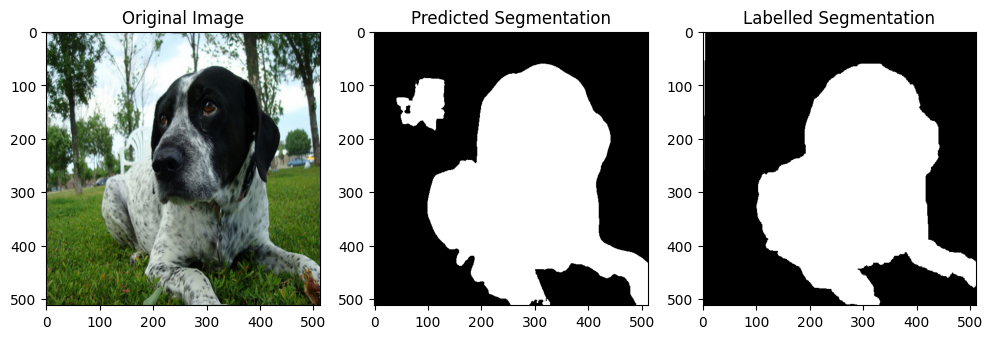

In [96]:
for idx in range(test_x.shape[0]):
    original_img = convert_to_image(test_x[idx])
    pred_img_mask = predicted_mask[idx].squeeze()
    lab_img_mask = test_y[idx].cpu().numpy().squeeze()
    fig, axes = plt.subplots(1, 3, figsize = (12, 4))
    axes[0].imshow(original_img)
    axes[0].set_title('Original Image')
    
    axes[1].imshow(pred_img_mask, cmap='gray')
    axes[1].set_title('Predicted Segmentation')

    axes[2].imshow(lab_img_mask, cmap = 'gray')
    axes[2].set_title('Labelled Segmentation')
    plt.show()